In [54]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sympy as sp

import ThermoAcousticClass

In [55]:
os.getcwd()

'/mnt/c/Users/admin/Documents/workspace/fyp'

# Acoustic Modes

The general matrix method will be solved for an open-open duct with no mean flow, assuming harmoic vibrations

$$ \mathbf{M} \begin{bmatrix} A \\ B \end{bmatrix} = \mathbf{0} $$

where 

$$ \mathbf{M} = \begin{bmatrix} 1 & -R_{u} \\ R_{d}exp\left(-\frac{i\omega L}{\bar{c}} \right) & -exp\left(\frac{i\omega L}{\bar{c}} \right) \end{bmatrix} $$


The aim is to solve for $\omega$ such that $det(\mathbf{M}) = 0$

In [130]:
# Defining variables
c = 345 # m/s, speed of sound
L = 0.75 # m, length of tube
Ru = -1 # upstream reflection coefficient
Rd = -1 # downstream refection coefficient
j = complex(0, 1)
e = np.e

# Function which returns the determinent of the matrix M
def matrix_det(w, Ru, Rd):
    det = -sp.exp(j*w*L/c) + Rd*Ru*sp.exp(-j*w*L/c)
    return det

In [131]:
# using solver to solve for w which gives det(M) = 0
w = sp.Symbol('w')
wl = sp.solveset(matrix_det(w, Ru, Rd), w, domain=sp.S.Complexes)
sp.pprint(wl)

{460.0⋅n⋅π │ n ∊ ℤ}


In [132]:
# Converting infinite set into generator object, taking first 100 elements and adding to a list
# Contains positive and negative numbers. Will only consider positive values of n (n=0 gives w=0)
wl_iterable = iter(wl)
wl_all = [complex(next(wl_iterable)) for i in range(100)] # Taking the first 100 solutions, can take more if wanted. Goes in order 0, 1, -1, 2, -2, ...

# taking positive values, want n = 1, 2, 3..., aka the odd indices in the wl_all list
w_n = [wl_all[i] for i in range(len(wl_all)) if (i%2 == 1)]
w_n = np.asarray(w_n)

In [141]:
# Function for calculating pressure fluctuations, saying A0 = 1

def p_fluc(k, Boundary=0):
    '''
    Returns pressure fluctuations within duct.
    Two different return values possible, depending on which 
    boundary condition is chosen. 
    Boundary=0 for boundary condition at x=0 (default), Boundary=1
    for boundary at x=L. In the simplest case, both should return
    the same values. 
    '''
    # Defining x axis
    x = np.linspace(0, L, 1000)[..., np.newaxis]
    
    if Boundary == 0:
        return e**((-j*k*x)) + 1/Ru*e**(j*k*x) # using BC and x = 0
    elif Boundary == 1:
        return e**((-j*k*x)) + Rd*e**(-2*j*k*L)*e**(j*k*x) # using BC at x = L

In [142]:
p = p_fluc(w_n/c, 0)
p.shape

(1000, 50)

In [143]:
def plot_modes(p_prime, labels=None):
    x = np.linspace(0, L, 1000)[..., np.newaxis]
    plt.plot(x, np.abs(p_prime), label = labels)
    plt.ylabel('|p\'|')
    plt.xlabel('Length')
    plt.legend(loc='upper left')
    plt.show()

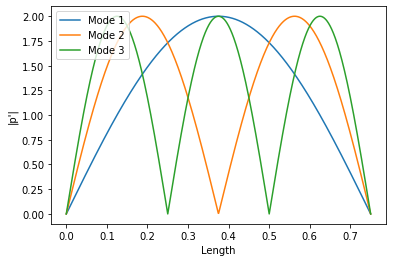

In [144]:
plot_modes(p[:,:3], ['Mode 1', 'Mode 2', 'Mode 3'])

# Viscous Effects

The assumptions for this viscous model are: 
- Low frequency, i.e. $kR_t<<1$
- High shear numbers, i.e. $Sh = R_t\left(\frac{\omega}{\nu}\right)^{\frac{1}{2}}>>1$

Where $R_t$ is the radius of the pipe

In [118]:
Rt = 0.005 #m
gamma = 1.4
T = 950 # K
density = 0.29 # kgm-3, https://www.engineeringtoolbox.com/air-density-specific-weight-d_600.html
Cp = 1175 # J/(Kg K), specific heat of air
Pr = 0.72 # Prandtl number, https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm

def Dynamic_viscosity(T):
    '''
    Dynamic viscosity of air as a function of temperature.
    Estimated by Sutherland's Law. 
    '''
    if (100 <= T <= 1000):
        return 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
    elif(1000 <= T <= 3000):
        return 2.653e-8*T+1.573e-5

kin_visc = Dynamic_viscosity(950)/density
    
def Shear(w, nu):
    return Rt*(w/nu)**(1/2)

def k_correction(w):
    Sh = Shear(w, kin_visc)
    return w/c*(1+(1-j)/np.sqrt(2)/Sh*(1+(gamma-1)/(Pr**(1/2)))-j/(Sh**2)*(1+(gamma-1)/(Pr**(1/5))-gamma/2*(gamma-1)/Pr))
    #return w/c*(1+(1-j)/np.sqrt(2)/Sh*(1+(gamma-1)/(Pr**(1/2))))

In [119]:
kc = k_correction(w_n)
p_vd = p_fluc(kc, 0) # Return values different depending on boundary condition? 

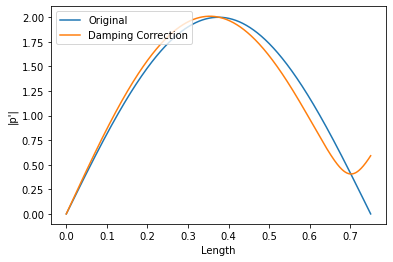

In [122]:
plot_modes(np.concatenate([p[:,0][...,np.newaxis], p_vd[:,0][...,np.newaxis]], axis=1), ['Original', 'Damping Correction']) 

# Non-reflective Boundary Conditions

In [191]:
# Assert that
w = 1840*np.pi

In [192]:
kc = k_correction(w)
a = np.real(kc)
b = np.imag(kc) # the negative part of the corrected wavenumber gives the damping!

In [193]:
x = np.linspace(0, L, 1000)[..., np.newaxis]
p_orig = np.cos(-w/c*x)
p_damping = np.exp(b*x)*np.cos(-a*x)
p_data = np.concatenate([p_orig, p_damping], axis=1)

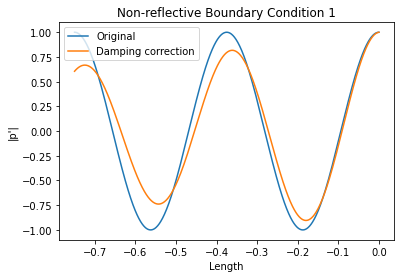

In [200]:
plt.plot(x, p_data, label = ['Original', 'Damping correction'])
plt.ylabel('|p\'|')
plt.xlabel('Length')
plt.legend(loc='upper left')
plt.title('Non-reflective Boundary Condition 1')
plt.show()

In [197]:
x = np.linspace(0, -L, 1000)[...,np.newaxis]
p_orig = np.cos(w/c*x)
p_damping = np.exp(-b*x)*np.cos(a*x)
p_data = np.concatenate([p_orig, p_damping], axis=1)

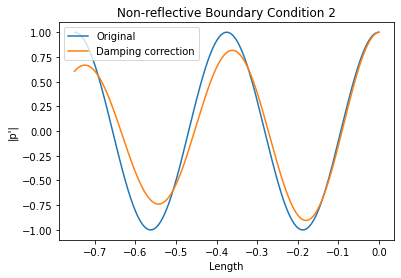

In [201]:
plt.plot(x, p_data, label = ['Original', 'Damping correction'])
plt.ylabel('|p\'|')
plt.xlabel('Length')
plt.legend(loc='upper left')
plt.title('Non-reflective Boundary Condition 2')
plt.show()